### Importar Librerias

In [27]:
import os
from gcloud import storage
from oauth2client.service_account import ServiceAccountCredentials

### Credenciales para gcs storage

In [2]:
credentials = ServiceAccountCredentials.from_json_keyfile_name('gcs_credentials.json')
gcs_client = storage.Client(credentials=credentials, project="Titanic")

### Guardar data en GCS Bucket

In [6]:
bucket = gcs_client.get_bucket('gcs-cluster')
blob = bucket.blob('titanic.csv')
blob.upload_from_filename('titanic.csv')

### Cargar data desde Bigquery para comenzar Análisis 

Usando la consola de GCS agregue el dataset en BigQuery y crear la tabla llamada `titanic`
Para el análisis utilizare BigQuery, Pandas y Seaborn. 

In [224]:
# librerias necesarias 
# !pip install --upgrade google-cloud-bigquery[pandas]
# !pip install --upgrade google-cloud-bigquery-storage[fastavro,pandas]

In [52]:
import google.auth 
from google.cloud import bigquery
from google.cloud import bigquery_storage_v1beta1 as bigquery_storage
google.cloud.bigquery.magics.context.use_bqstorage_api = True

Por la consola, genere variables de ambiente para poder conectarme a GCS y luego 
    utilizar auth.default() para que tome reconozca automaticamente las credenciales, 
    ID del projecto,etc.
    `os.environ['GOOGLE_APPLICATION_CREDENTIALS']`


In [41]:
credentials, project = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

In [226]:
# crear bigquery y bigquery_storage para poder generar consultas y además de guardare el dataframe en bigstorage.

In [61]:
bigquery = bigquery.Client(credentials=credentials, project=project)
bigquery_storage = bigquery_storage.BigQueryStorageClient(credentials=credentials)

### Data Cleaning


In [176]:
query = """ 
SELECT * FROM `fabled-ruler-239923.titanic.titanic`
"""

df = bigquery.query(query).result().to_dataframe(bigquery_storage)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,None,S
1,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
2,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,None,S
3,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,None,S
4,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,None,S


Cantidad de personas Edad nula ("NaN" en Pandas)

In [158]:
len(df[df['Age'].isnull()])

177

Debido a que más adelante deseo trabajar con edad y ver la distribución. Filtraré los registros de la base de datos al momento de hacer el KDE

Generos en el dataset 

In [161]:
df['Sex'].unique()

array(['male', 'female'], dtype=object)

Veamos si tenemos outliers, por ejemplo en edad. 

In [174]:
df[df['Age'].notnull()]['Age'].sort_values(ascending=False).unique()

array([80.  , 74.  , 71.  , 70.5 , 70.  , 66.  , 65.  , 64.  , 63.  ,
       62.  , 61.  , 60.  , 59.  , 58.  , 57.  , 56.  , 55.5 , 55.  ,
       54.  , 53.  , 52.  , 51.  , 50.  , 49.  , 48.  , 47.  , 46.  ,
       45.5 , 45.  , 44.  , 43.  , 42.  , 41.  , 40.5 , 40.  , 39.  ,
       38.  , 37.  , 36.5 , 36.  , 35.  , 34.5 , 34.  , 33.  , 32.5 ,
       32.  , 31.  , 30.5 , 30.  , 29.  , 28.5 , 28.  , 27.  , 26.  ,
       25.  , 24.5 , 24.  , 23.5 , 23.  , 22.  , 21.  , 20.5 , 20.  ,
       19.  , 18.  , 17.  , 16.  , 15.  , 14.5 , 14.  , 13.  , 12.  ,
       11.  , 10.  ,  9.  ,  8.  ,  7.  ,  6.  ,  5.  ,  4.  ,  3.  ,
        2.  ,  1.  ,  0.92,  0.83,  0.75,  0.67,  0.42])

In [175]:
df[df['Age'] <= 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
195,165,0,3,"Panula, Master. Eino Viljami",male,1.00,4,1,3101295,39.6875,None,S
276,387,0,3,"Goodwin, Master. Sidney Leonard",male,1.00,5,2,CA 2144,46.9000,None,S
593,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,None,S
621,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,None,S
665,184,1,2,"Becker, Master. Richard F",male,1.00,2,1,230136,39.0000,F4,S
680,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,None,S
702,173,1,3,"Johnson, Miss. Eleanor Ileen",female,1.00,1,1,347742,11.1333,None,S
722,789,1,3,"Dean, Master. Bertram Vere",male,1.00,1,2,C.A. 2315,20.5750,None,S
756,828,1,2,"Mallet, Master. Andre",male,1.00,0,2,S.C./PARIS 2079,37.0042,None,C
785,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,None,C


Más adelante, se podria comparar las variables de Fare y Survived, por lo que revisaré si hay algún registro raro en Fare

In [181]:
df[df['Fare'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,None,S
1,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
2,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,None,S
3,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,None,S
4,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,None,S
5,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,None,S
6,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,None,S
7,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,None,S
8,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,None,S
9,675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0,None,S


Existen algunos pasajeros que tienen Fare 0 y además da la casualidad que su gran mayoría con edad Nula. Por lo que no se tendrán en cuenta para el análisis.

### Data Analysis

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

##### Cantidad de personas por genero

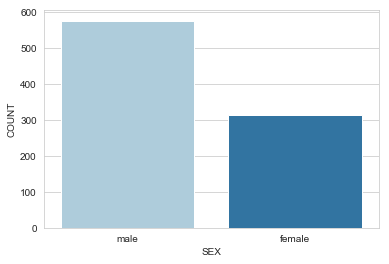

In [136]:
sns.set_style('whitegrid')

query = """
SELECT count(1) COUNT, SEX
FROM `fabled-ruler-239923.titanic.titanic` 
group by SEX
"""

df_gender = bigquery.query(query).result().to_dataframe(bigquery_storage)

sns.barplot(x='SEX', y='COUNT', data=df_gender, palette='Paired')

In [145]:
df_gender

,COUNT,SEX
0,577,male
1,314,female


##### Distribución de pasajeros por edad 

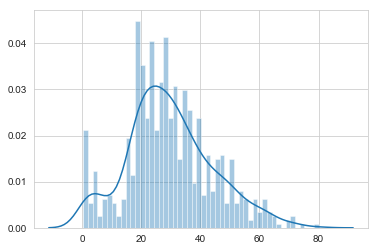

In [201]:
query = """
SELECT AGE
FROM `fabled-ruler-239923.titanic.titanic` 
where age is not null 
"""

df_age = bigquery.query(query).result().to_dataframe(bigquery_storage)

sns.distplot(df_age, bins=50)

##### Comparar distribucion de sobrevivientes por genero

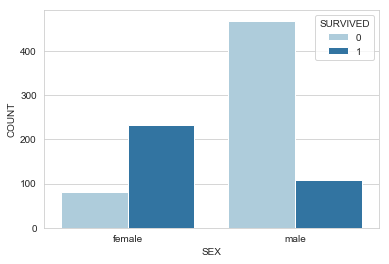

In [135]:
query = """
SELECT count(1) COUNT, SURVIVED, SEX
FROM `fabled-ruler-239923.titanic.titanic` 
group by SURVIVED, SEX
"""

df_gender_survived = bigquery.query(query).result().to_dataframe(bigquery_storage)

sns.barplot(x='SEX', y='COUNT', data=df_gender_survived, hue='SURVIVED', palette='Paired')

Comparar sobrevivientes entre rango de edad, ya teniendo en cuenta de que anteriormente el KDE la gran mayoria esta entre los 15 y 30 años, es de esperar que los rangos entre esas categorias sean más altos.

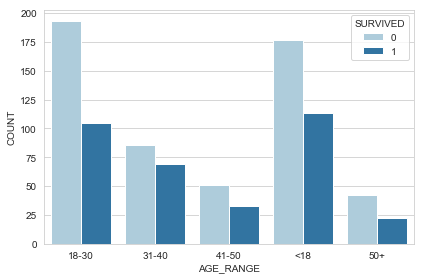

In [139]:
query = """
SELECT count(1) COUNT, SURVIVED, 
(CASE WHEN AGE > 50 THEN '50+'  
 WHEN AGE >= 41 THEN '41-50' 
 WHEN AGE >= 31 THEN '31-40' 
 WHEN AGE >= 18 THEN '18-30' ELSE '<18' END) AS AGE_RANGE
FROM `fabled-ruler-239923.titanic.titanic` 
group by SURVIVED, AGE_RANGE
"""

df_age_survived = bigquery.query(query).result().to_dataframe(bigquery_storage)

sns.barplot(x='AGE_RANGE', y='COUNT', data=df_age_survived, hue=df_age_survived.SURVIVED, palette='Paired')
plt.tight_layout()

##### Comparación de variables entre Clases de Pasajero y Survived

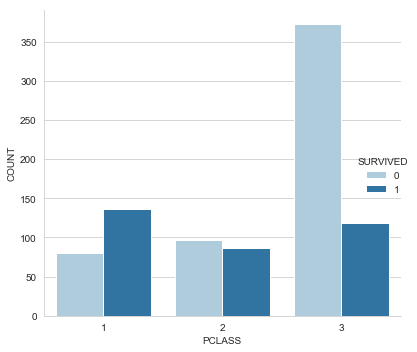

In [222]:
query = """
SELECT PCLASS, SURVIVED, COUNT(1) COUNT
FROM `fabled-ruler-239923.titanic.titanic` 
GROUP BY PCLASS, SURVIVED
"""

df_fare_survived = bigquery.query(query).result().to_dataframe(bigquery_storage)

sns.catplot(x='PCLASS',  y='COUNT', hue='SURVIVED', kind='bar', data=df_fare_survived, palette='Paired')
# sns.countplot(x='FARE', data=df_fare_survived)
plt.tight_layout()